In [1]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np

# Convex Hull playground

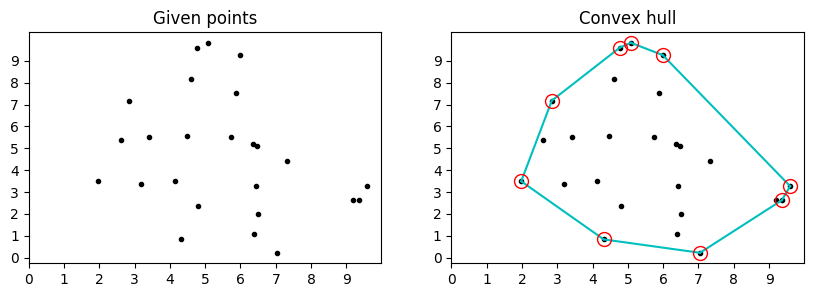

In [2]:
points = np.random.random_sample(size=(25, 2))*10

hull = ConvexHull(points)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))

for ax in (ax1, ax2):
    ax.plot(points[:, 0], points[:, 1], '.', color='k')
    if ax == ax1:
        ax.set_title('Given points')
    else:
        ax.set_title('Convex hull')
        for simplex in hull.simplices:
            ax.plot(points[simplex, 0], points[simplex, 1], 'c')
        ax.plot(points[hull.vertices, 0], points[hull.vertices, 1], 'o', mec='r', color='none', lw=1, markersize=10)
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
plt.show()

# Data Analysis

In [3]:
import sqlite3
import pandas as pd
import scipy
import seaborn
from enum import Enum

In [4]:
path = "/home/stefano/git/uni/MasterThesisFlySim/python_part/data.db"
con = sqlite3.connect(f"file:{path}?mode=ro", uri=True)

In [5]:
class EnvironmentType(Enum):
    GWO = "GWO"
    SMA = "SMA"

class WhoWon(Enum):
    DefenderWon = "DefenderWon"
    AttackerWon = "AttackerWon"

In [6]:
# Load in Data

# Todo: Modify query so that we get all parameters where we are above a certain WinRatio.
# So we can do the convex hull on it

query = """
SELECT
  EnvironmentType,
  MaxRounds,
  LineOfSight,
  COUNT(CASE WHEN WhoWon = 'AttackerWon' THEN 1 END) AS AttackerWonCount,
  COUNT(CASE WHEN WhoWon = 'DefenderWon' THEN 1 END) AS DefenderWonCount,
  ROUND(CAST(COUNT(CASE WHEN WhoWon = 'AttackerWon' THEN 1 END) AS REAL) / COUNT(CASE WHEN WhoWon = 'DefenderWon' THEN 1 END), 3) AS WinRatio,
  COUNT(CASE WHEN WhoWon = 'AttackerWon' THEN 1 END) + COUNT(CASE WHEN WhoWon = 'DefenderWon' THEN 1 END) AS WinSum /* Just as check. Must be the same for all rows if our data set is complete and our query is correct.*/
FROM
  my_table
WHERE
  NrDefenders = 0
GROUP BY
  MaxRounds,
  EnvironmentType,
  LineOfSight
ORDER BY
  WinRatio DESC;
"""

query = "SELECT * from my_table"
df = pd.read_sql_query(query, con)

# Change type for one column from string to enum
df['EnvironmentType'] = df['EnvironmentType'].map(lambda x: EnvironmentType[x])
df = df.astype({'EnvironmentType': 'category'})
df['WhoWon'] = df['WhoWon'].map(lambda x: WhoWon[x])
df = df.astype({'WhoWon': 'category'})

# Verify that result of SQL query is stored in the dataframe
df.head()

,EnvironmentType,MaxRounds,PlayedRounds,WhoWon,LineOfSight,NrAttackers,NrDefenders,MaxSpeed,AreaSideLength,TargetHitRadius
0,EnvironmentType.GWO,4500,3944,WhoWon.AttackerWon,200.000000,50,2,25.0,100.0,1.5
1,EnvironmentType.GWO,4500,4500,WhoWon.DefenderWon,6.623377,25,2,25.0,100.0,1.5
2,EnvironmentType.SMA,4500,4500,WhoWon.DefenderWon,6.623377,25,2,25.0,100.0,1.5
3,EnvironmentType.GWO,4500,4500,WhoWon.DefenderWon,20.000000,25,2,25.0,100.0,1.5
4,EnvironmentType.SMA,4500,4500,WhoWon.DefenderWon,20.000000,25,2,25.0,100.0,1.5


In [7]:
df.describe()

,MaxRounds,PlayedRounds,LineOfSight,NrAttackers,NrDefenders,MaxSpeed,AreaSideLength,TargetHitRadius
count,86400.000000,86400.000000,86400.000000,86400.000000,86400.00000,86400.000000,86400.000000,86400.0
mean,7250.000000,7152.434086,75.541126,28.333333,1.50000,30.000000,175.000000,1.5
std,2750.015914,2803.277237,88.175496,16.499254,1.11804,14.719687,75.000434,0.0
min,4500.000000,1.000000,6.623377,10.000000,0.00000,15.000000,100.000000,1.5
25%,4500.000000,4500.000000,6.623377,10.000000,0.75000,15.000000,100.000000,1.5
50%,7250.000000,4500.000000,20.000000,25.000000,1.50000,25.000000,175.000000,1.5
75%,10000.000000,10000.000000,200.000000,50.000000,2.25000,50.000000,250.000000,1.5
max,10000.000000,10000.000000,200.000000,50.000000,3.00000,50.000000,250.000000,1.5


In [8]:
df.dtypes

EnvironmentType    category
MaxRounds             int64
PlayedRounds          int64
WhoWon             category
LineOfSight         float64
NrAttackers           int64
NrDefenders           int64
MaxSpeed            float64
AreaSideLength      float64
TargetHitRadius     float64
dtype: object

In [9]:
# Calculate Win ratio per parameter set

grouped = df.groupby(['MaxRounds', 'LineOfSight', 'NrAttackers', 'NrDefenders', 'MaxSpeed', 'AreaSideLength', 'TargetHitRadius', 'EnvironmentType'])['WhoWon'].value_counts().unstack(fill_value=0).reset_index()
grouped['AttackerToDefenderRatio'] = grouped[WhoWon.AttackerWon] / (grouped[WhoWon.DefenderWon] + grouped[WhoWon.AttackerWon])
grouped.columns.name = None
grouped = grouped.sort_values(by='AttackerToDefenderRatio', ascending=True)
grouped

,MaxRounds,LineOfSight,NrAttackers,NrDefenders,MaxSpeed,AreaSideLength,TargetHitRadius,EnvironmentType,WhoWon.AttackerWon,WhoWon.DefenderWon,AttackerToDefenderRatio
0,4500,6.623377,10,0,15.0,100.0,1.5,EnvironmentType.GWO,0,100,0.00
433,10000,6.623377,10,0,15.0,100.0,1.5,EnvironmentType.SMA,0,100,0.00
434,10000,6.623377,10,0,15.0,250.0,1.5,EnvironmentType.GWO,0,100,0.00
435,10000,6.623377,10,0,15.0,250.0,1.5,EnvironmentType.SMA,0,100,0.00
436,10000,6.623377,10,0,25.0,100.0,1.5,EnvironmentType.GWO,0,100,0.00
...,...,...,...,...,...,...,...,...,...,...,...
249,4500,20.000000,50,0,50.0,100.0,1.5,EnvironmentType.SMA,74,26,0.74
681,10000,20.000000,50,0,50.0,100.0,1.5,EnvironmentType.SMA,77,23,0.77
393,4500,200.000000,50,0,50.0,100.0,1.5,EnvironmentType.SMA,84,16,0.84
777,10000,200.000000,25,0,50.0,100.0,1.5,EnvironmentType.SMA,88,12,0.88


Mean attacker to defender ratio over all simulations:
2.326388888888889%


<Axes: ylabel='Frequency'>

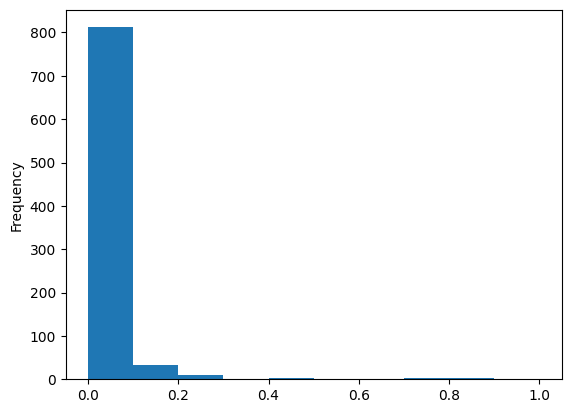

In [10]:
# Mean over all simulation runs
mean_ratio = grouped.AttackerToDefenderRatio.mean()
print(f"Mean attacker to defender ratio over all simulations:\n{mean_ratio*100.0}%")
grouped.AttackerToDefenderRatio.plot.hist()

Mean attacker to defender ratio for 0 defenders:
5.3657407407407405%


<Axes: ylabel='Frequency'>

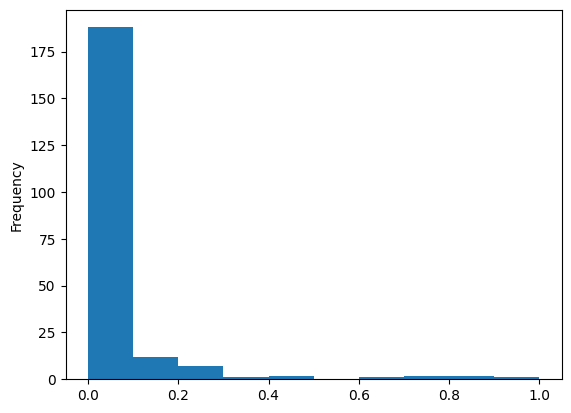

In [11]:
# Check how many times Attackers won without any defenders in the simulation.
# This should be 100%
zero_defenders = grouped[grouped.NrDefenders == 0]
mean_ratio = zero_defenders.AttackerToDefenderRatio.mean()
print(f"Mean attacker to defender ratio for 0 defenders:\n{mean_ratio*100.0}%")
zero_defenders.AttackerToDefenderRatio.plot.hist()

In [12]:
# Example: Cutoff of 0.10 means that we only get combinations where attackers won less-or-equal 10% of the simulations.
cutoff = 0.10 # between 0.0 and 1.0.

filtered = grouped[grouped["AttackerToDefenderRatio"] <= cutoff]
filtered

,MaxRounds,LineOfSight,NrAttackers,NrDefenders,MaxSpeed,AreaSideLength,TargetHitRadius,EnvironmentType,WhoWon.AttackerWon,WhoWon.DefenderWon,AttackerToDefenderRatio
0,4500,6.623377,10,0,15.0,100.0,1.5,EnvironmentType.GWO,0,100,0.0
433,10000,6.623377,10,0,15.0,100.0,1.5,EnvironmentType.SMA,0,100,0.0
434,10000,6.623377,10,0,15.0,250.0,1.5,EnvironmentType.GWO,0,100,0.0
435,10000,6.623377,10,0,15.0,250.0,1.5,EnvironmentType.SMA,0,100,0.0
436,10000,6.623377,10,0,25.0,100.0,1.5,EnvironmentType.GWO,0,100,0.0
...,...,...,...,...,...,...,...,...,...,...,...
812,10000,200.000000,25,3,50.0,100.0,1.5,EnvironmentType.GWO,10,90,0.1
429,4500,200.000000,50,3,50.0,100.0,1.5,EnvironmentType.SMA,10,90,0.1
273,4500,20.000000,50,2,50.0,100.0,1.5,EnvironmentType.SMA,10,90,0.1
261,4500,20.000000,50,1,50.0,100.0,1.5,EnvironmentType.SMA,10,90,0.1


<Axes: ylabel='Frequency'>

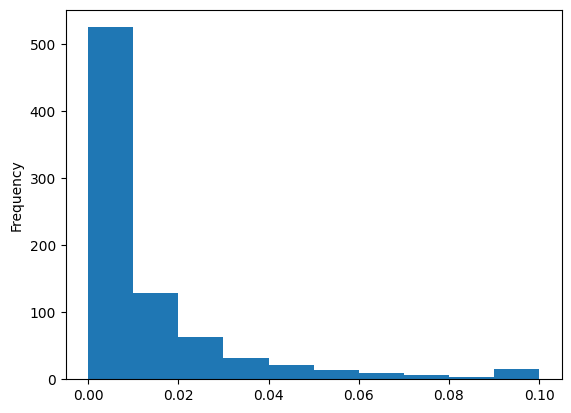

In [13]:
filtered.AttackerToDefenderRatio.plot.hist()

Got 3697 simplices


/home/stefano/git/uni/MasterThesisFlySim/python_part/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


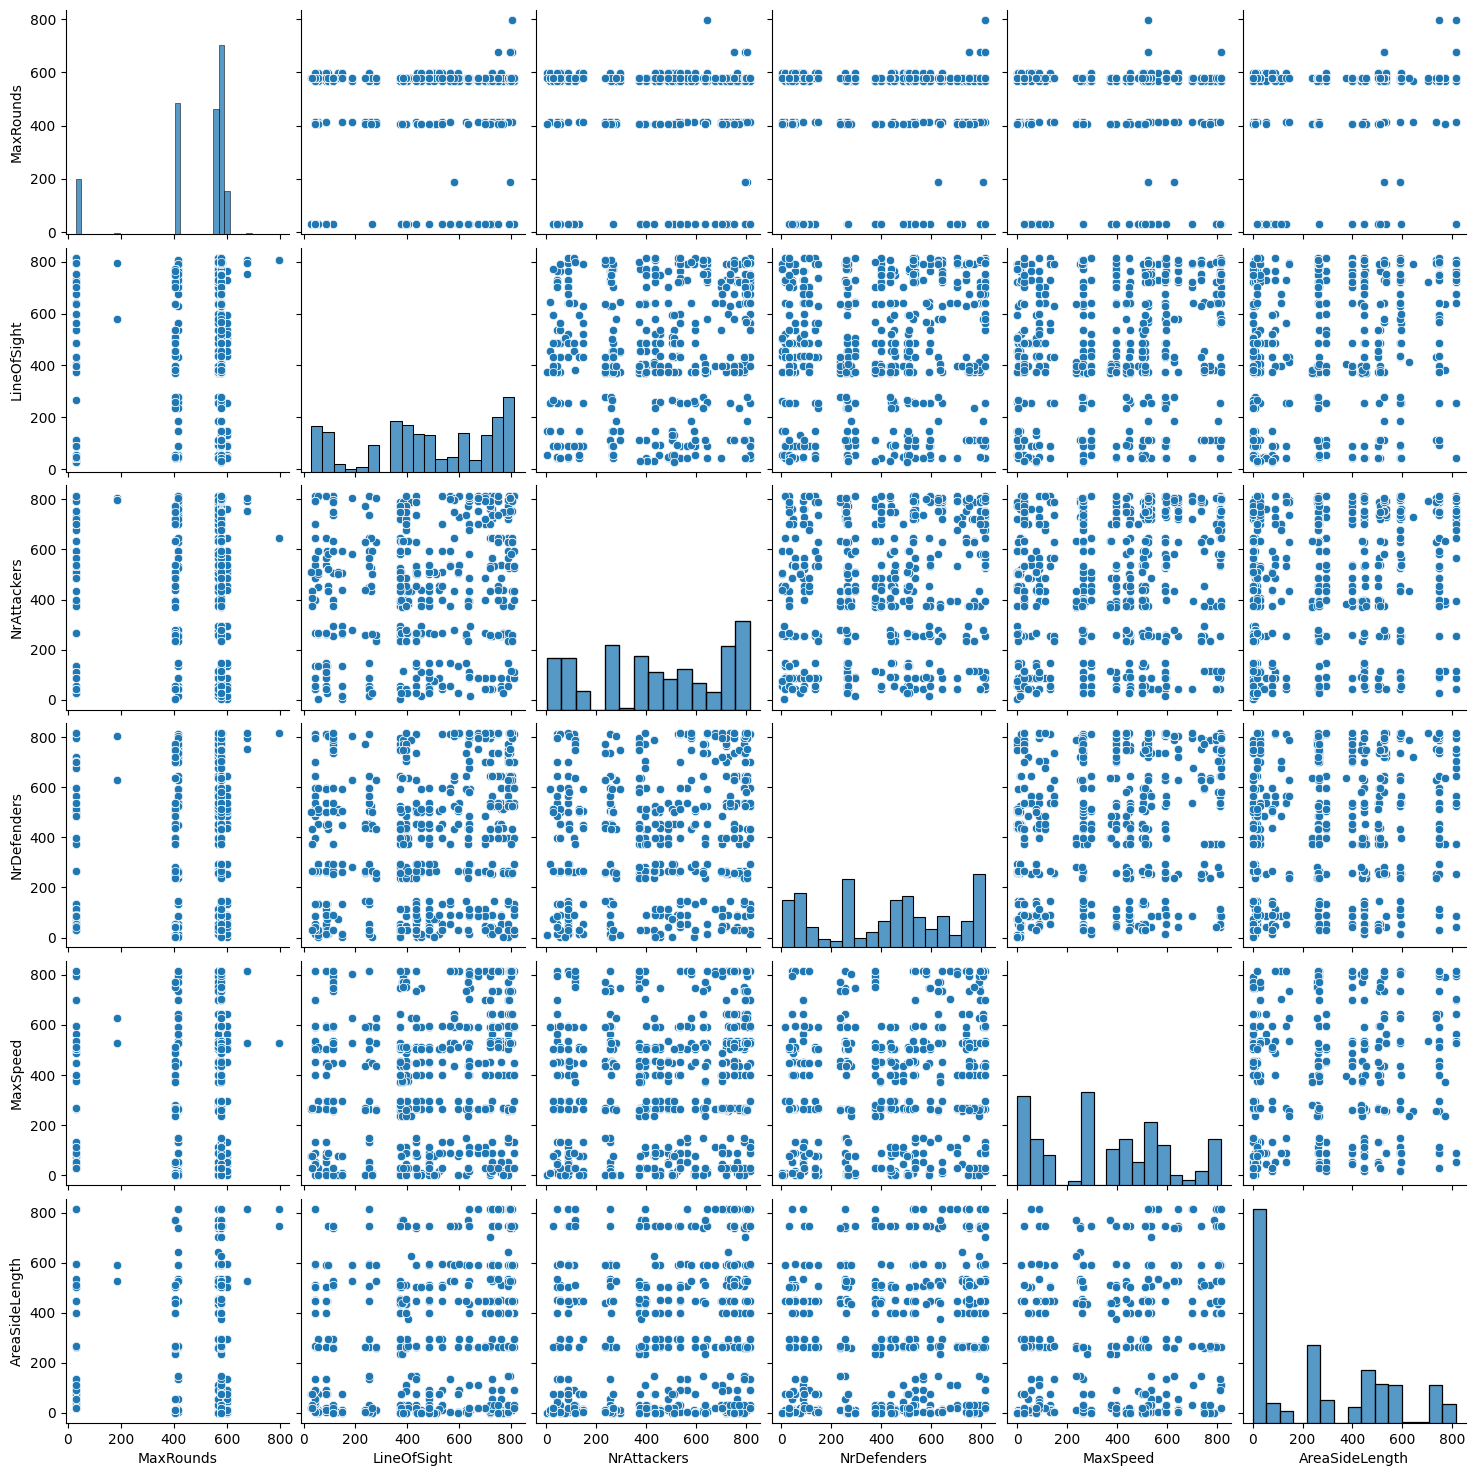

In [14]:
#parameters_for_hull = ['MaxRounds', 'LineOfSight', 'NrAttackers', 'NrDefenders', 'MaxSpeed', 'AreaSideLength', 'TargetHitRadius']
parameters_for_hull = ['MaxRounds', 'LineOfSight', 'NrAttackers', 'NrDefenders', 'MaxSpeed', 'AreaSideLength']
hull: scipy.spatial._qhull.ConvexHull = ConvexHull(filtered[parameters_for_hull])
print(f"Got {len(hull.simplices)} simplices")
simplices = pd.DataFrame(hull.simplices, columns = parameters_for_hull)
seaborn.pairplot(simplices)

In [15]:
# Next Step: find out how many points are in and out of the hull.
def points_in_hull(p, hull, tol=1e-12):
    return np.all(hull.equations[:,:-1] @ p.T + np.repeat(hull.equations[:,-1][None,:], len(p), axis=0).T <= tol, 0)

idx_in_hull = points_in_hull(df[parameters_for_hull], hull)
is_in = len(idx_in_hull[idx_in_hull == True])
is_out = len(idx_in_hull[idx_in_hull == False])
print(f"Sims in hull {is_in}, Sims outside hull {is_out}, {len(idx_in_hull)}, {is_in + is_out}")

Sims in hull 84200, Sims outside hull 2200, 86400, 86400


In [16]:
# Extract the vertices of the convex hull
vertices = hull.points[hull.vertices]

# Calculate the minimum and maximum coordinates along each axis
min_coords = np.min(vertices, axis=0)
max_coords = np.max(vertices, axis=0)

# Print the bounding box coordinates
print("Minimum Coordinates:", list(zip(min_coords, parameters_for_hull)))
print("Maximum Coordinates:", list(zip(min_coords, parameters_for_hull)))

data = {'Parameter': parameters_for_hull, 'Minimum': min_coords, 'Maximum': max_coords, 'Dataset Min': df[parameters_for_hull].min(), 'Dataset Max': df[parameters_for_hull].max()}
table_df = pd.DataFrame(data)
table_df

Minimum Coordinates: [(4500.0, 'MaxRounds'), (6.623377, 'LineOfSight'), (10.0, 'NrAttackers'), (0.0, 'NrDefenders'), (15.0, 'MaxSpeed'), (100.0, 'AreaSideLength')]
Maximum Coordinates: [(4500.0, 'MaxRounds'), (6.623377, 'LineOfSight'), (10.0, 'NrAttackers'), (0.0, 'NrDefenders'), (15.0, 'MaxSpeed'), (100.0, 'AreaSideLength')]


,Parameter,Minimum,Maximum,Dataset Min,Dataset Max
MaxRounds,MaxRounds,4500.000000,10000.0,4500.000000,10000.0
LineOfSight,LineOfSight,6.623377,200.0,6.623377,200.0
NrAttackers,NrAttackers,10.000000,50.0,10.000000,50.0
NrDefenders,NrDefenders,0.000000,3.0,0.000000,3.0
MaxSpeed,MaxSpeed,15.000000,50.0,15.000000,50.0
AreaSideLength,AreaSideLength,100.000000,250.0,100.000000,250.0


In [17]:
# Load data again but with all variable parameters except nr defenders

query = """
SELECT
  EnvironmentType,
  MaxRounds,
  LineOfSight,
  NrAttackers,
  MaxSpeed,
  AreaSideLength,
  TargetHitRadius,
  COUNT(CASE WHEN WhoWon = 'AttackerWon' THEN 1 END) AS AttackerWonCount,
  COUNT(CASE WHEN WhoWon = 'DefenderWon' THEN 1 END) AS DefenderWonCount,
  ROUND(CAST(COUNT(CASE WHEN WhoWon = 'AttackerWon' THEN 1 END) AS REAL) / (COUNT(CASE WHEN WhoWon = 'DefenderWon' THEN 1 END) + COUNT(CASE WHEN WhoWon = 'AttackerWon' THEN 1 END)), 4) AS WinRatio,
  COUNT(CASE WHEN WhoWon = 'AttackerWon' THEN 1 END) + COUNT(CASE WHEN WhoWon = 'DefenderWon' THEN 1 END) AS WinSum /* Just as check. Must be the same for all rows if our data set is complete and our query is correct.*/
FROM
  my_table
WHERE
  NrDefenders = 0
GROUP BY
  MaxRounds,
  EnvironmentType,
  LineOfSight,
  NrAttackers,
  MaxSpeed,
  AreaSideLength,
  TargetHitRadius
ORDER BY
  WinRatio DESC;
"""

zero_defenders = pd.read_sql_query(query, con)

# Change type for one column from string to enum
zero_defenders['EnvironmentType'] = zero_defenders['EnvironmentType'].map(lambda x: EnvironmentType[x])
zero_defenders = zero_defenders.astype({'EnvironmentType': 'category'})

# Verify that result of SQL query is stored in the dataframe
zero_defenders


,EnvironmentType,MaxRounds,LineOfSight,NrAttackers,MaxSpeed,AreaSideLength,TargetHitRadius,AttackerWonCount,DefenderWonCount,WinRatio,WinSum
0,EnvironmentType.SMA,10000,200.0,50,50.0,100.0,1.5,100,0,1.00,100
1,EnvironmentType.SMA,10000,200.0,25,50.0,100.0,1.5,88,12,0.88,100
2,EnvironmentType.SMA,4500,200.0,50,50.0,100.0,1.5,84,16,0.84,100
3,EnvironmentType.SMA,10000,20.0,50,50.0,100.0,1.5,77,23,0.77,100
4,EnvironmentType.SMA,4500,20.0,50,50.0,100.0,1.5,74,26,0.74,100
...,...,...,...,...,...,...,...,...,...,...,...
211,EnvironmentType.SMA,10000,20.0,10,25.0,250.0,1.5,0,100,0.00,100
212,EnvironmentType.SMA,10000,20.0,25,25.0,250.0,1.5,0,100,0.00,100
213,EnvironmentType.SMA,10000,200.0,10,15.0,100.0,1.5,0,100,0.00,100
214,EnvironmentType.SMA,10000,200.0,10,15.0,250.0,1.5,0,100,0.00,100


In [18]:
zero_defenders[zero_defenders.WinRatio >= 0.20]

,EnvironmentType,MaxRounds,LineOfSight,NrAttackers,MaxSpeed,AreaSideLength,TargetHitRadius,AttackerWonCount,DefenderWonCount,WinRatio,WinSum
0,EnvironmentType.SMA,10000,200.000000,50,50.0,100.0,1.5,100,0,1.00,100
1,EnvironmentType.SMA,10000,200.000000,25,50.0,100.0,1.5,88,12,0.88,100
2,EnvironmentType.SMA,4500,200.000000,50,50.0,100.0,1.5,84,16,0.84,100
3,EnvironmentType.SMA,10000,20.000000,50,50.0,100.0,1.5,77,23,0.77,100
4,EnvironmentType.SMA,4500,20.000000,50,50.0,100.0,1.5,74,26,0.74,100
5,EnvironmentType.SMA,10000,20.000000,25,50.0,100.0,1.5,66,34,0.66,100
6,EnvironmentType.SMA,4500,20.000000,25,50.0,100.0,1.5,49,51,0.49,100
7,EnvironmentType.SMA,4500,200.000000,25,50.0,100.0,1.5,45,55,0.45,100
8,EnvironmentType.SMA,10000,200.000000,50,50.0,250.0,1.5,36,64,0.36,100
9,EnvironmentType.SMA,10000,20.000000,50,50.0,250.0,1.5,30,70,0.30,100


In [19]:
# Load data again but with all variable parameters and one winratio per defender count

# Get all used defender counts
query = "SELECT DISTINCT NrDefenders FROM my_table ORDER BY NrDefenders;"
defender_counts = pd.read_sql_query(query, con)
defender_counts = list(defender_counts["NrDefenders"])
print(f"Found defender values: {defender_counts}")

query = """
SELECT
  EnvironmentType,
  MaxRounds,
  LineOfSight,
  NrAttackers,
  MaxSpeed,
  AreaSideLength,
  TargetHitRadius,
  COUNT(CASE WHEN WhoWon = 'AttackerWon' THEN 1 END) AS AttackerWonCount,
  COUNT(CASE WHEN WhoWon = 'DefenderWon' THEN 1 END) AS DefenderWonCount,
  ROUND(CAST(COUNT(CASE WHEN WhoWon = 'AttackerWon' THEN 1 END) AS REAL) / (COUNT(CASE WHEN WhoWon = 'DefenderWon' THEN 1 END) + COUNT(CASE WHEN WhoWon = 'AttackerWon' THEN 1 END)), 4) AS WinRatio,
  COUNT(CASE WHEN WhoWon = 'AttackerWon' THEN 1 END) + COUNT(CASE WHEN WhoWon = 'DefenderWon' THEN 1 END) AS WinSum /* Just as check. Must be the same for all rows if our data set is complete and our query is correct.*/
FROM
  my_table
WHERE
  NrDefenders = :nrdefenders
GROUP BY
  MaxRounds,
  EnvironmentType,
  LineOfSight,
  NrAttackers,
  MaxSpeed,
  AreaSideLength,
  TargetHitRadius
ORDER BY
  WinRatio DESC;
"""

results = dict()

for defender in defender_counts:
    res = pd.read_sql_query(query, con, params={"nrdefenders": defender})
    # Change type for one column from string to enum
    res['EnvironmentType'] = res['EnvironmentType'].map(lambda x: EnvironmentType[x])
    res = res.astype({'EnvironmentType': 'category'})
    results[defender] = res

# Verify that result of SQL query is stored in the dataframe
#results


Found defender values: [0, 1, 2, 3]


In [20]:
base = results[0] # Base is the case with zero defenders
base = base.rename(columns={"WinRatio": "WinRatio_0"})
base = base[["MaxRounds","EnvironmentType","LineOfSight","NrAttackers","MaxSpeed","AreaSideLength","TargetHitRadius", "WinRatio_0"]]

for nrdefender in defender_counts:
    if nrdefender == 0:
        continue
    print(f"nrdefender: {nrdefender}")
    join_on = ["MaxRounds","EnvironmentType","LineOfSight","NrAttackers","MaxSpeed","AreaSideLength","TargetHitRadius"]
    right = results[nrdefender][join_on + ["WinRatio"]]
    right = right.rename(columns={"WinRatio": f"WinRatio_{nrdefender}"})
    base = base.merge(
        #right=results[nrdefender][join_on + ["WinRatio"]],
        right=right,
        how="inner",
        on=join_on,
        suffixes=(None, f"_COLLISION{nrdefender}"),
        validate="one_to_one"
    )

for nrdefender in defender_counts:
    if nrdefender == 0:
        continue
    print(f"Compare_0_to_{nrdefender}")
    base[f"Compare_0_to_{nrdefender}"] = (base[f"WinRatio_{nrdefender}"] - base["WinRatio_0"]) / (base["WinRatio_0"])

# Example for Compare_0_to_{nrdefender} if value A -> B
# Example: 0.50 -> 0.25: "The attackers win 50% less."
# Example: 0.50 -> 1.0: "The attackers win 100% more."
#base[base["WinRatio_0"] >= 0.20].sort_values(by="Compare_0_to_1")
base[base["WinRatio_0"] >= 0.20]

nrdefender: 1
nrdefender: 2
nrdefender: 3
Compare_0_to_1
Compare_0_to_2
Compare_0_to_3


,MaxRounds,EnvironmentType,LineOfSight,NrAttackers,MaxSpeed,AreaSideLength,TargetHitRadius,WinRatio_0,WinRatio_1,WinRatio_2,WinRatio_3,Compare_0_to_1,Compare_0_to_2,Compare_0_to_3
0,10000,EnvironmentType.SMA,200.000000,50,50.0,100.0,1.5,1.00,0.11,0.13,0.13,-0.890000,-0.870000,-0.870000
1,10000,EnvironmentType.SMA,200.000000,25,50.0,100.0,1.5,0.88,0.15,0.11,0.02,-0.829545,-0.875000,-0.977273
2,4500,EnvironmentType.SMA,200.000000,50,50.0,100.0,1.5,0.84,0.16,0.12,0.10,-0.809524,-0.857143,-0.880952
3,10000,EnvironmentType.SMA,20.000000,50,50.0,100.0,1.5,0.77,0.15,0.08,0.07,-0.805195,-0.896104,-0.909091
4,4500,EnvironmentType.SMA,20.000000,50,50.0,100.0,1.5,0.74,0.10,0.10,0.09,-0.864865,-0.864865,-0.878378
5,10000,EnvironmentType.SMA,20.000000,25,50.0,100.0,1.5,0.66,0.10,0.10,0.04,-0.848485,-0.848485,-0.939394
6,4500,EnvironmentType.SMA,20.000000,25,50.0,100.0,1.5,0.49,0.11,0.02,0.07,-0.775510,-0.959184,-0.857143
7,4500,EnvironmentType.SMA,200.000000,25,50.0,100.0,1.5,0.45,0.07,0.09,0.02,-0.844444,-0.800000,-0.955556
8,10000,EnvironmentType.SMA,200.000000,50,50.0,250.0,1.5,0.36,0.09,0.02,0.02,-0.750000,-0.944444,-0.944444
9,10000,EnvironmentType.SMA,20.000000,50,50.0,250.0,1.5,0.30,0.02,0.01,0.01,-0.933333,-0.966667,-0.966667


In [21]:
# Print table in Latex format for paper / master thesis.
print("    \\begin{tabular}{|" + "c|"*7 + "|" + "c|"*7 + "}")

table_caption = [
    "Simulation Steps $el$", "Environment Type", "Maximum Vision Distance $vd$", "Number Attackers $na$",
    "Maximum Agent Speed $as$", "Area side length $sl$", "Target Hit Radius $hr$",
    "$m_s$ with $nd=0$", "$m_s$ with $nd=1$", "$m_s$ with $nd=2$", "$m_s$ with $nd=3$",
    "$c_1$", "$c_2$", "$c_3$",
]

print(" "*8 + "\\hline " + " & ".join(["\\rotatebox{90}{" + tc + "}" for tc in table_caption]) + "\\\\ \\hline\\hline")

for (idx, row) in base[base["WinRatio_0"] >= 0.20].iterrows():
    round_digits = 3
    to_print = [
        str(row["MaxRounds"]),
        str(row["EnvironmentType"].name),
        str(round(row["LineOfSight"], round_digits)),
        str(row["NrAttackers"]),
        str(row["MaxSpeed"]),
        str(row["AreaSideLength"]),
        str(row["TargetHitRadius"]),
        str(round(row["WinRatio_0"], round_digits)),
        str(round(row["WinRatio_1"], round_digits)),
        str(round(row["WinRatio_2"], round_digits)),
        str(round(row["WinRatio_3"], round_digits)),
        str(round(row["Compare_0_to_1"], round_digits)) + (" \cellcolor{yellow}" if row["Compare_0_to_1"] > 0.0 else ""),
        str(round(row["Compare_0_to_2"], round_digits)) + (" \cellcolor{yellow}" if row["Compare_0_to_2"] > 0.0 else ""),
        str(round(row["Compare_0_to_3"], round_digits)) + (" \cellcolor{yellow}" if row["Compare_0_to_3"] > 0.0 else ""),
    ]
    print("        " + " & ".join(to_print) + "\\\\ \hline")
print("    \\end{tabular}")

    \begin{tabular}{|c|c|c|c|c|c|c||c|c|c|c|c|c|c|}
        \hline \rotatebox{90}{Simulation Steps $el$} & \rotatebox{90}{Environment Type} & \rotatebox{90}{Maximum Vision Distance $vd$} & \rotatebox{90}{Number Attackers $na$} & \rotatebox{90}{Maximum Agent Speed $as$} & \rotatebox{90}{Area side length $sl$} & \rotatebox{90}{Target Hit Radius $hr$} & \rotatebox{90}{$m_s$ with $nd=0$} & \rotatebox{90}{$m_s$ with $nd=1$} & \rotatebox{90}{$m_s$ with $nd=2$} & \rotatebox{90}{$m_s$ with $nd=3$} & \rotatebox{90}{$c_1$} & \rotatebox{90}{$c_2$} & \rotatebox{90}{$c_3$}\\ \hline\hline
        10000 & SMA & 200.0 & 50 & 50.0 & 100.0 & 1.5 & 1.0 & 0.11 & 0.13 & 0.13 & -0.89 & -0.87 & -0.87\\ \hline
        10000 & SMA & 200.0 & 25 & 50.0 & 100.0 & 1.5 & 0.88 & 0.15 & 0.11 & 0.02 & -0.83 & -0.875 & -0.977\\ \hline
        4500 & SMA & 200.0 & 50 & 50.0 & 100.0 & 1.5 & 0.84 & 0.16 & 0.12 & 0.1 & -0.81 & -0.857 & -0.881\\ \hline
        10000 & SMA & 20.0 & 50 & 50.0 & 100.0 & 1.5 & 0.77 & 0.15 & 0.0

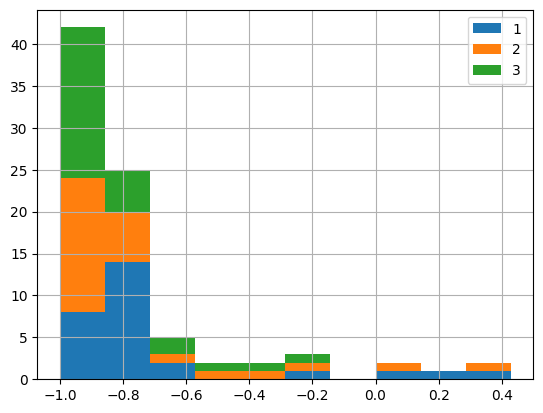

In [22]:
plt.hist(base[base["WinRatio_0"] >= 0.10][["Compare_0_to_1", "Compare_0_to_2", "Compare_0_to_3"]], stacked=True)
plt.grid(True)
plt.legend((1,2,3))
plt.show()

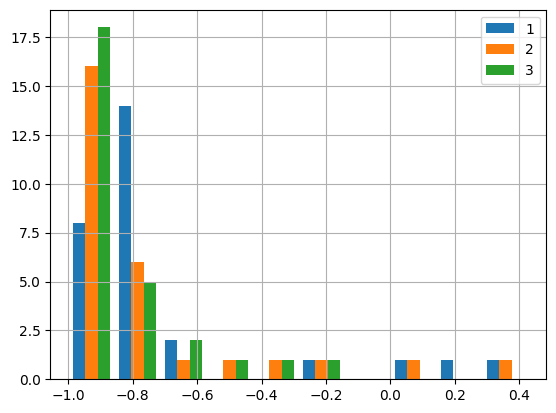

In [23]:
plt.hist(base[base["WinRatio_0"] >= 0.10][["Compare_0_to_1", "Compare_0_to_2", "Compare_0_to_3"]])
plt.grid(True)
plt.legend((1,2,3))
plt.show()

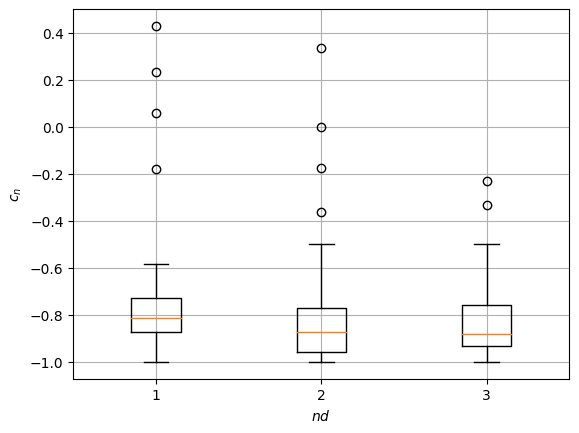

In [24]:
plt.boxplot(base[base["WinRatio_0"] >= 0.10][["Compare_0_to_1", "Compare_0_to_2", "Compare_0_to_3"]])
plt.grid(True)
plt.ylabel("$c_n$")
plt.xlabel("$nd$")
plt.show()
#plt.savefig("/tmp/boxplot.eps")